In [1]:
# notebook to check what the problem is

In [2]:
# import libraries
import math
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import time
import os
import glob

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [3]:
def bulirsch_stoer_3d_optimized(position, velocity, timestep, Fx, Fy, Fz, args_x, args_y, args_z, N, h, q, p):
    # step 1: modified midpoint method with step size h
    x_values1, y_values1, z_values1, Vx_values1, Vy_values1, Vz_values1 = modified_midpoint_method_optimized(position, velocity, Fx, Fy, Fz, args_x, args_y, args_z, N, h)
    
    # step 2: modified midpoint method with step size h/q
    N_2 = int((timestep * q)/h)
    h_2 = h/q
    
    x_values2, y_values2, z_values2, Vx_values2, Vy_values2, Vz_values2 = modified_midpoint_method_optimized(position, velocity, Fx, Fy, Fz, args_x, args_y, args_z, N_2, h_2)
    
    # step 3: Richardson Extrapolation
    x_final = Richardson_extrapolation(x_values1, x_values2, q, p)
    y_final = Richardson_extrapolation(y_values1, y_values2, q, p)
    z_final = Richardson_extrapolation(z_values1, z_values2, q, p)
    
    Vx_final = Richardson_extrapolation(Vx_values1, Vx_values2, q, p)
    Vy_final = Richardson_extrapolation(Vy_values1, Vy_values2, q, p)
    Vz_final = Richardson_extrapolation(Vz_values1, Vz_values2, q, p)
    
    return (x_final, y_final, z_final), (Vx_final, Vy_final, Vz_final)


def Richardson_extrapolation(f_h, f_hq, q, p):
    return f_h + (f_h - f_hq)/((q**(-p)) -1)


def modified_midpoint_method_optimized(position, velocity, Fx, Fy, Fz, args_x, args_y, args_z, N, h):
    x_values = [None] * (N + 1)
    y_values = [None] * (N + 1)
    z_values = [None] * (N + 1)
    
    Vx_values = [None] * (N + 1)
    Vy_values = [None] * (N + 1)
    Vz_values = [None] * (N + 1)
    
    Fx_values = [None] * (N + 1)
    Fy_values = [None] * (N + 1)
    Fz_values = [None] * (N + 1)
    
    # prep
    x_values[0] = position[0]
    y_values[0] = position[1]
    z_values[0] = position[2]
    
    Vx_values[0] = velocity[0]
    Vy_values[0] = velocity[1]
    Vz_values[0] = velocity[2]
    
    Fx_values[0] = Fx(args_x, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    Fy_values[0] = Fy(args_y, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    Fz_values[0] = Fz(args_z, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    
    # step 1
    # print("step:", 1)
    x_values[1] = x_values[0] + Vx_values[0] * h
    y_values[1] = y_values[0] + Vy_values[0] * h
    z_values[1] = z_values[0] + Vz_values[0] * h

    Vx_values[1] = Vx_values[0] + Fx_values[0] * h
    Vy_values[1] = Vy_values[0] + Fy_values[0] * h
    Vz_values[1] = Vz_values[0] + Fz_values[0] * h

    Fx_values[1] = Fx(args_x, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    Fy_values[1] = Fy(args_y, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    Fz_values[1] = Fz(args_z, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])

    # steps 2 +
    for n in range(2, N+1):
        # print("step:", n)
        x_values[n] = x_values[n-2] + Vx_values[n-1] * 2 * h
        y_values[n] = y_values[n-2] + Vy_values[n-1] * 2 * h
        z_values[n] = z_values[n-2] + Vz_values[n-1] * 2 * h

        Vx_values[n] = Vx_values[n-2] + Fx_values[n-1] * 2 * h
        Vy_values[n] = Vy_values[n-2] + Fy_values[n-1] * 2 * h
        Vz_values[n] = Vz_values[n-2] + Fz_values[n-1] * 2 * h

        Fx_values[n] = Fx(args_x, Vx_values[n], Vy_values[n], Vz_values[n], x_values[n], y_values[n], z_values[n])
        Fy_values[n] = Fy(args_y, Vx_values[n], Vy_values[n], Vz_values[n], x_values[n], y_values[n], z_values[n])
        Fz_values[n] = Fz(args_z, Vx_values[n], Vy_values[n], Vz_values[n], x_values[n], y_values[n], z_values[n])
    
    # final step
    x_values = 1/2 * (x_values[N] + x_values[N-1] + (h * Vx_values[N]))
    y_values = 1/2 * (y_values[N] + y_values[N-1] + (h * Vy_values[N]))
    z_values = 1/2 * (z_values[N] + z_values[N-1] + (h * Vz_values[N]))

    Vx_values = 1/2 * (Vx_values[N] + Vx_values[N-1] + (h * Fx_values[N]))
    Vy_values = 1/2 * (Vy_values[N] + Vy_values[N-1] + (h * Fy_values[N]))
    Vz_values = 1/2 * (Vz_values[N] + Vz_values[N-1] + (h * Fz_values[N]))
    
    return x_values, y_values, z_values, Vx_values, Vy_values, Vz_values


def runga_kutta_3d_optimized(position, velocity, timestep, Fx, Fy, Fz, args_x, args_y, args_z):
    x_values = [None] * 4
    y_values = [None] * 4
    z_values = [None] * 4
    
    Vx_values = [None] * 4
    Vy_values = [None] * 4
    Vz_values = [None] * 4
    
    Fx_values = [None] * 4
    Fy_values = [None] * 4
    Fz_values = [None] * 4
    
    # step 1
    x_values[0] = position[0]
    y_values[0] = position[1]
    z_values[0] = position[2]
    
    Vx_values[0] = velocity[0]
    Vy_values[0] = velocity[1]
    Vz_values[0] = velocity[2]
    
    Fx_values[0] = Fx(args_x, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    Fy_values[0] = Fy(args_y, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    Fz_values[0] = Fz(args_z, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    
    # step 2
    x_values[1] = x_values[0] + Vx_values[0] * timestep/2
    y_values[1] = y_values[0] + Vy_values[0] * timestep/2
    z_values[1] = z_values[0] + Vz_values[0] * timestep/2
    
    Vx_values[1] = Vx_values[0] + Fx_values[0] * timestep/2
    Vy_values[1] = Vy_values[0] + Fy_values[0] * timestep/2
    Vz_values[1] = Vz_values[0] + Fz_values[0] * timestep/2
    
    Fx_values[1] = Fx(args_x, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    Fy_values[1] = Fy(args_y, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    Fz_values[1] = Fz(args_z, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    
    # step 3
    x_values[2] = x_values[0] + Vx_values[1] * timestep/2
    y_values[2] = y_values[0] + Vy_values[1] * timestep/2
    z_values[2] = z_values[0] + Vz_values[1] * timestep/2
    
    Vx_values[2] = Vx_values[0] + Fx_values[1] * timestep/2
    Vy_values[2] = Vy_values[0] + Fy_values[1] * timestep/2
    Vz_values[2] = Vz_values[0] + Fz_values[1] * timestep/2
    
    Fx_values[2] = Fx(args_x, Vx_values[2], Vy_values[2], Vz_values[2], x_values[2], y_values[2], z_values[2])
    Fy_values[2] = Fy(args_y, Vx_values[2], Vy_values[2], Vz_values[2], x_values[2], y_values[2], z_values[2])
    Fz_values[2] = Fz(args_z, Vx_values[2], Vy_values[2], Vz_values[2], x_values[2], y_values[2], z_values[2])
    
    # step 4
    x_values[3] = x_values[0] + Vx_values[2] * timestep
    y_values[3] = y_values[0] + Vy_values[2] * timestep
    z_values[3] = z_values[0] + Vz_values[2] * timestep
    
    Vx_values[3] = Vx_values[0] + Fx_values[2] * timestep
    Vy_values[3] = Vy_values[0] + Fy_values[2] * timestep
    Vz_values[3] = Vz_values[0] + Fz_values[2] * timestep
    
    Fx_values[3] = Fx(args_x, Vx_values[3], Vy_values[3], Vz_values[3], x_values[3], y_values[3], z_values[3])
    Fy_values[3] = Fy(args_y, Vx_values[3], Vy_values[3], Vz_values[3], x_values[3], y_values[3], z_values[3])
    Fz_values[3] = Fz(args_z, Vx_values[3], Vy_values[3], Vz_values[3], x_values[3], y_values[3], z_values[3])
    
    # step 5
    x_final = x_values[0] + ((Vx_values[0] + 2*Vx_values[1] + 2*Vx_values[2] + Vx_values[3])*timestep)/6
    y_final = y_values[0] + ((Vy_values[0] + 2*Vy_values[1] + 2*Vy_values[2] + Vy_values[3])*timestep)/6
    z_final = z_values[0] + ((Vz_values[0] + 2*Vz_values[1] + 2*Vz_values[2] + Vz_values[3])*timestep)/6
    
    Vx_final = Vx_values[0] + ((Fx_values[0] +2*Fx_values[1] +2*Fx_values[2] + Fx_values[3])*timestep)/6
    Vy_final = Vy_values[0] + ((Fy_values[0] +2*Fy_values[1] +2*Fy_values[2] + Fy_values[3])*timestep)/6
    Vz_final = Vz_values[0] + ((Fz_values[0] +2*Fz_values[1] +2*Fz_values[2] + Fz_values[3])*timestep)/6
    
    return (x_final, y_final, z_final), (Vx_final, Vy_final, Vz_final)




In [4]:
def gravitational_force(args, Vx, Vy, Vz, x, y, z):
    n = args[0] # position of body in array of all bodies
    m = args[1] # mass array
    component = args[2] # "x", "y", or "z"
    x_all = args[3] # last x position of all bodies (array)
    y_all = args[4] # last x position of all bodies (array)
    z_all = args[5] # last x position of all bodies (array)
    G_or_const = args[6]
    
    F = 0

    for body in range(len(x_all)):
        if body != n:
            # claculate distance between 2 bodies
            r =  math.sqrt((x_all[body] - x)**2 + (y_all[body] - y)**2 + (z_all[body] - z)**2)
            # print("r:", r)
            if component == "x":
                F -= G_or_const * m[body] * ((x - x_all[body])/r**3)
            elif component == "y":
                F -= G_or_const * m[body] * ((y - y_all[body])/r**3)
            elif component == "z":
                F -= G_or_const * m[body] * ((z - z_all[body])/r**3)      
    return F

def run_simulation(input_file, n_timesteps, timestep, func_integration, args, return_velocity):
    df = pd.read_csv(input_file)
    bodies = list(df['body'])
    df = df.set_index('body')
    n_bodies = len(df)
    # print(n_bodies, "bodies:", bodies)
    display(df)
    
    # set array of masses and normalize
    m = list(df["mass"])
    m = [i/mass_sun for i in m]
    # print("Masses:", m)

    # initialization positions and velocities
    x = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    y = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    z = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    Vx = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    Vy = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    Vz = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    
    for n in range(n_bodies):
        row = df.loc[bodies[n]] 
        x[n][0] = float(row.x)/AU
        y[n][0] = float(row.y)/AU
        z[n][0] = float(row.z)/AU

        Vx[n][0] = float(row.Vx)*(year/AU)
        Vy[n][0] = float(row.Vy)*(year/AU)
        Vz[n][0] = float(row.Vz)*(year/AU)
    
    if func_integration == "Bulirsch-Stoer" or func_integration == "Bulirsch-Stoer_optimized":
        N = args[0]
        h = args[1]
        q = args[2]
        p = args[3]
    
    start_time = time.time()
    # run simulation
    for t in range(n_timesteps):
        # set array with latest position for all bodies
        x_last_all = [None] * n_bodies
        y_last_all = [None] * n_bodies
        z_last_all = [None] * n_bodies
        
        for n in range(n_bodies):
            x_last_all[n] = x[n][t]
            y_last_all[n] = y[n][t]
            z_last_all[n] = z[n][t]
            
        for n in range(n_bodies):
            # for a specific body: p_components are its position, c_components are its velocity components
            p_components = (x_last_all[n], y_last_all[n], z_last_all[n])
            v_components = (Vx[n][t], Vy[n][t], Vz[n][t])

            args_x = (n, m, "x", x_last_all, y_last_all, z_last_all, norm_const)
            args_y = (n, m, "y", x_last_all, y_last_all, z_last_all, norm_const)
            args_z = (n, m, "z", x_last_all, y_last_all, z_last_all, norm_const)
            
            if func_integration == "Bulirsch-Stoer":
                p_components, v_components = bulirsch_stoer_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
            elif func_integration == "Bulirsch-Stoer_optimized":
                p_components, v_components = bulirsch_stoer_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
            elif func_integration == "Runga-Kutta":
                p_components, v_components = runga_kutta_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
            elif func_integration == "Runga-Kutta_optimized":
                p_components, v_components = runga_kutta_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
        
            # add new value in arrays
            x[n][t+1] = p_components[0]
            y[n][t+1] = p_components[1]
            z[n][t+1] = p_components[2]

            Vx[n][t+1] = v_components[0]
            Vy[n][t+1] = v_components[1]
            Vz[n][t+1] = v_components[2]
            
    exec_time = time.time() - start_time
    if return_velocity == True:
        return n_bodies, bodies, x, y, z, exec_time, Vx, Vy, Vz
    return n_bodies, bodies, x, y, z, exec_time

# instead of keeping all positions in memory in array, this function stores positions in files
def run_simulation_save(input_file, n_timesteps, timestep, func_integration, args, folder, step_save):
    df = pd.read_csv(input_file)
    bodies = list(df['body'])
    df = df.set_index('body')
    n_bodies = len(df)
    # print(n_bodies, "bodies:", bodies)
    display(df)
    
    # set array of masses and normalize
    m = list(df["mass"])
    m = [i/mass_sun for i in m]
    # print("Masses:", m)

    # initialization positions and velocities in temporary arrays (changed at each step)
    x = [None] * n_bodies
    y = [None] * n_bodies
    z = [None] * n_bodies
    Vx = [None] * n_bodies
    Vy = [None] * n_bodies
    Vz = [None] * n_bodies
    
    # initiaization folder
    create_empty_folder(folder)
    
    for n in range(n_bodies):
        row = df.loc[bodies[n]]
        x[n] = row.x/AU
        y[n] = row.y/AU
        z[n] = row.z/AU

        Vx[n] = row.Vx*(year/AU)
        Vy[n] = row.Vy*(year/AU)
        Vz[n] = row.Vz*(year/AU)
    # save
    save_timestep(bodies, x, y, z, Vx, Vy, Vz, folder, 0)
    
    if func_integration == "Bulirsch-Stoer" or func_integration == "Bulirsch-Stoer_optimized":
        N = args[0]
        h = args[1]
        q = args[2]
        p = args[3]
    
    start_time = time.time()
    # run simulation
    for t in range(1, n_timesteps + 1):
    
        for n in range(n_bodies):
            # for a specific body: p_components are its position, c_components are its velocity components
            p_components = (x[n], y[n], z[n])
            v_components = (Vx[n], Vy[n], Vz[n])

            args_x = (n, m, "x", x, y, z, norm_const)
            args_y = (n, m, "y", x, y, z, norm_const)
            args_z = (n, m, "z", x, y, z, norm_const)
            
            if func_integration == "Bulirsch-Stoer":
                p_components, v_components = bulirsch_stoer_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
            elif func_integration == "Bulirsch-Stoer_optimized":
                p_components, v_components = bulirsch_stoer_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
            elif func_integration == "Runga-Kutta":
                p_components, v_components = runga_kutta_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
            elif func_integration == "Runga-Kutta_optimized":
                p_components, v_components = runga_kutta_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
        
            # save new values in arrays
            x[n] = p_components[0]
            y[n] = p_components[1]
            z[n] = p_components[2]

            Vx[n] = v_components[0]
            Vy[n] = v_components[1]
            Vz[n] = v_components[2]
            
        # save values in files
        if t % step_save == 0:
            save_timestep(bodies, x, y, z, Vx, Vy, Vz, folder, t)   
                 
    exec_time = time.time() - start_time
    return n_bodies, bodies, exec_time

def create_empty_folder(folder):
    if os.path.exists(folder):
        files = glob.glob(folder + '/*')
        for f in files:
            os.remove(f)
    else:
        os.mkdir(folder)

def save_timestep(bodies, x, y, z, Vx, Vy, Vz, folder, timestep):
    # create dataframe
    df = pd.DataFrame()
    df["body"] = bodies
    df["x"] = x
    df["y"] = y
    df["z"] = z
    df["Vx"] = Vx
    df["Vy"] = Vy
    df["Vz"] = Vz
    
    df.to_csv(folder + "/t_%s.csv"%(str(timestep)), index = False)

def get_positions_from_files(folder, timesteps, n_bodies):
    # position arrays
    n_timesteps = len(timesteps)
    x = [[None] * (n_timesteps) for _ in range(n_bodies)]
    y = [[None] * (n_timesteps) for _ in range(n_bodies)]
    z = [[None] * (n_timesteps) for _ in range(n_bodies)]
    
    # populate position arrays
    index = 0
    for timestep in timesteps:
        df = pd.read_csv(folder + "/t_%s.csv"%(str(timestep)))
        x_tmp = list(df["x"])
        y_tmp = list(df["y"])
        z_tmp = list(df["z"])
        
        for n in range(n_bodies):
            x[n][index] = x_tmp[n]
            y[n][index] = y_tmp[n]
            z[n][index] = z_tmp[n]  
        index += 1
        
    return x, y, z

In [5]:
# non-dimentionalize code
# universal gravitation constant
G = 6.67259e-20  # (km**3/kg/s**2)
mass_sun = 1.989e30 # kg
AU = 1.496e8 #km
year = 3.156e7 #s
norm_const = (G * mass_sun * (year**2))/(AU**3)
# print(norm_const)

## 1. check sun and trakectories of planets

In [6]:
# initial conditions: store in arrays
# NASA JBL 01/01/2023 for eath and sun (vector table)
# observer: solar system barycenter 
input_file = "bodies2.csv"

n_days_timestep = 2 # timestep in number of days
n_days_total = 365 * 165 # total number of days I want to simulate
n_timesteps = int(n_days_total/n_days_timestep) # number of timesteps for simulation
print("Number of timesteps:", n_timesteps)

timestep = (86400/year) * n_days_timestep # (86400/year) = 1 day in non dimensional
print("Timestep:", timestep)

# variables for Bulirsch-Stoer method
N = 4
h = timestep/N
q = 2
p = 1

func_integration = "Bulirsch-Stoer_optimized" #"Runga-Kutta" "Bulisrsch-Stoer"  "Runga-Kutta_optimized"
args_bulirsch_stoer = [N, h, q, p]

Number of timesteps: 30112
Timestep: 0.005475285171102661


In [7]:
n_bodies, bodies, x, y, z, exec_time = run_simulation(input_file, n_timesteps, timestep, func_integration, args_bulirsch_stoer, False)
print(exec_time)
print(bodies)


# X =-1.354630417531006E+06 Y = 1.420546299731827E+04 Z = 3.143940434895225E+04
#  VX= 1.636302711538109E-03 VY=-1.558286309774412E-02 VZ= 8.961626340290262E-05

,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,-29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


72.12140274047852
['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']


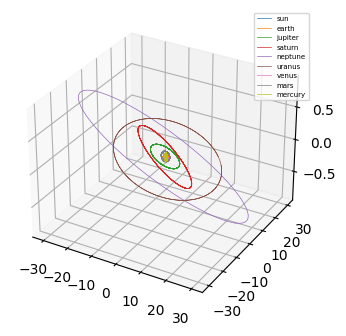

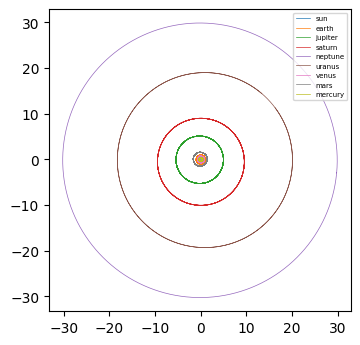

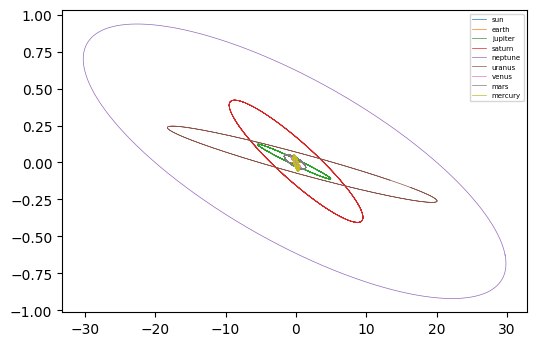

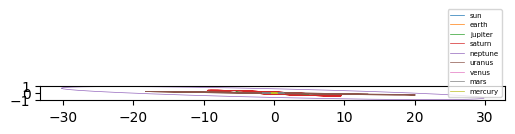

In [8]:
ax = plt.figure(dpi = 100).add_subplot(projection='3d')
for i in range(n_bodies):
    ax.plot(x[i], y[i], z[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x[i], y[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
# ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x[i], z[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x[i], z[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

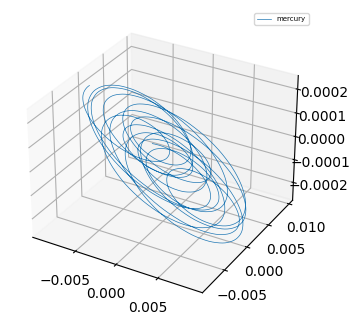

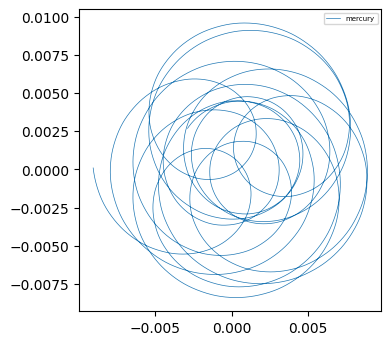

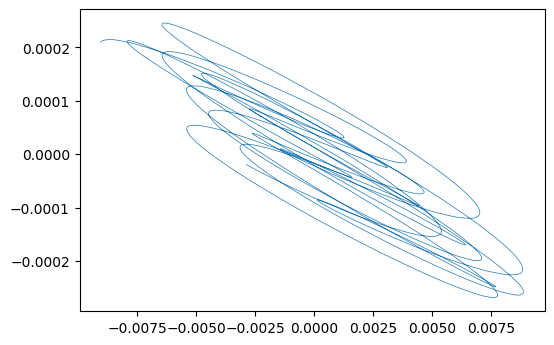

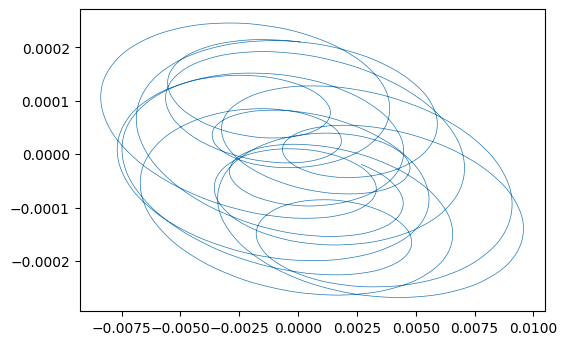

In [9]:
ax = plt.figure(dpi = 100).add_subplot(projection='3d')
ax.plot(x[0], y[0], z[0], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
ax.set_aspect("equal")
ax.plot(x[0], y[0], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()


fig = plt.figure(dpi = 100)
plt.plot(x[0], z[0], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
plt.plot(y[0], z[0], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

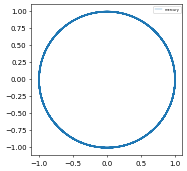

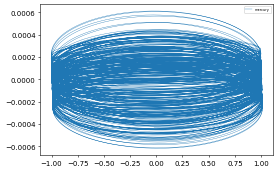

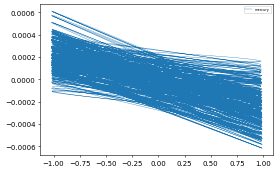

In [10]:
# ['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']

i_body = 1

fig = plt.figure(dpi = 50)
ax = plt.subplot()
ax.set_aspect("equal")
ax.plot(x[i_body], y[i_body], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 50)
ax = plt.subplot()
# ax.set_aspect("equal")
plt.plot(x[i_body], z[i_body], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 50)
ax = plt.subplot()
# ax.set_aspect("equal")
plt.plot(y[i_body], z[i_body], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

## 2. check how trajectories of the sun evolve by adding planet one after another

In [93]:
# initial conditions: store in arrays
# NASA JBL 01/01/2023 for eath and sun (vector table)
# observer: solar system barycenter 
input_file = "bodies_tmp.csv"

n_days_timestep = 2 # timestep in number of days
n_days_total = 365 * 10 # total number of days I want to simulate
n_timesteps = int(n_days_total/n_days_timestep) # number of timesteps for simulation
print("Number of timesteps:", n_timesteps)

timestep = (86400/year) * n_days_timestep # (86400/year) = 1 day in non dimensional
print("Timestep:", timestep)

# variables for Bulirsch-Stoer method
N = 4
h = timestep/N
q = 2
p = 1

func_integration = "Bulirsch-Stoer_optimized" #"Runga-Kutta" "Bulisrsch-Stoer"  "Runga-Kutta_optimized"
args_bulirsch_stoer = [N, h, q, p]

Number of timesteps: 1825
Timestep: 0.005475285171102661


In [94]:
n_bodies, bodies, x, y, z, exec_time = run_simulation(input_file, n_timesteps, timestep, func_integration, args_bulirsch_stoer, False)
print(exec_time)
print(bodies)

,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26


1.4232232570648193
['sun', 'earth', 'jupiter', 'saturn']


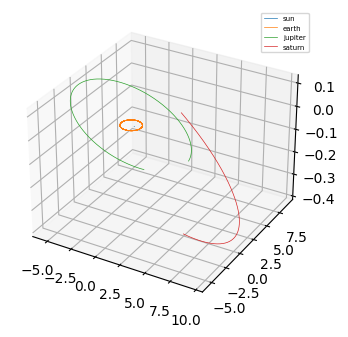

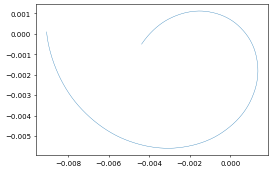

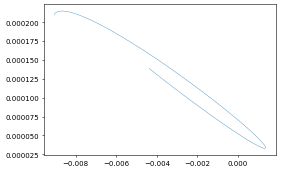

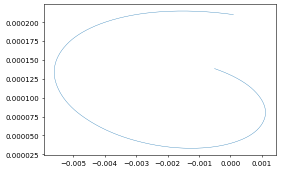

In [95]:
ax = plt.figure(dpi = 100).add_subplot(projection='3d')
for i in range(n_bodies):
    ax.plot(x[i], y[i], z[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

# ['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']

i_body = 0

fig = plt.figure(dpi = 50)
plt.plot(x[i_body], y[i_body], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()


fig = plt.figure(dpi = 50)
plt.plot(x[i_body], z[i_body], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 50)
plt.plot(y[i_body], z[i_body], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

## 3. Try to fix the sun

In [154]:
def run_simulation_fix_sun(input_file, n_timesteps, timestep, func_integration, args):
    df = pd.read_csv(input_file)
    bodies = list(df['body'])
    df = df.set_index('body')
    n_bodies = len(df)
    # print(n_bodies, "bodies:", bodies)
    display(df)
    
    # set array of masses and normalize
    m = list(df["mass"])
    m = [i/mass_sun for i in m]
    # print("Masses:", m)

    # initialization positions and velocities
    x = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    y = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    z = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    Vx = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    Vy = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    Vz = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    
    for n in range(n_bodies):
        row = df.loc[bodies[n]]
        x[n][0] = row.x/AU
        y[n][0] = row.y/AU
        z[n][0] = row.z/AU

        Vx[n][0] = row.Vx*(year/AU)
        Vy[n][0] = row.Vy*(year/AU)
        Vz[n][0] = row.Vz*(year/AU)
    
    if func_integration == "Bulirsch-Stoer" or func_integration == "Bulirsch-Stoer_optimized":
        N = args[0]
        h = args[1]
        q = args[2]
        p = args[3]
    
    start_time = time.time()
    # run simulation
    for t in range(n_timesteps):
        # set array with latest position for all bodies
        x_last_all = [None] * n_bodies
        y_last_all = [None] * n_bodies
        z_last_all = [None] * n_bodies
        
        for n in range(n_bodies):
            x_last_all[n] = x[n][t]
            y_last_all[n] = y[n][t]
            z_last_all[n] = z[n][t]
            
        for n in range(n_bodies):
            
            # for a specific body: p_components are its position, c_components are its velocity components
            p_components = (x_last_all[n], y_last_all[n], z_last_all[n])
            v_components = (Vx[n][t], Vy[n][t], Vz[n][t])
            
            if n != 0: # if it s not the sun
                args_x = (n, m, "x", x_last_all, y_last_all, z_last_all, norm_const)
                args_y = (n, m, "y", x_last_all, y_last_all, z_last_all, norm_const)
                args_z = (n, m, "z", x_last_all, y_last_all, z_last_all, norm_const)

                if func_integration == "Bulirsch-Stoer":
                    p_components, v_components = bulirsch_stoer_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
                elif func_integration == "Bulirsch-Stoer_optimized":
                    p_components, v_components = bulirsch_stoer_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
                elif func_integration == "Runga-Kutta":
                    p_components, v_components = runga_kutta_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
                elif func_integration == "Runga-Kutta_optimized":
                    p_components, v_components = runga_kutta_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)

            # add new value in arrays
            x[n][t+1] = p_components[0]
            y[n][t+1] = p_components[1]
            z[n][t+1] = p_components[2]

            Vx[n][t+1] = v_components[0]
            Vy[n][t+1] = v_components[1]
            Vz[n][t+1] = v_components[2]
            
    exec_time = time.time() - start_time
    return n_bodies, bodies, x, y, z, exec_time




In [182]:
# initial conditions: store in arrays
# NASA JBL 01/01/2023 for eath and sun (vector table)
# observer: solar system barycenter 
input_file = "bodies2.csv"

n_days_timestep = 2 # timestep in number of days
n_days_total = 365 * 165 # total number of days I want to simulate
n_timesteps = int(n_days_total/n_days_timestep) # number of timesteps for simulation
print("Number of timesteps:", n_timesteps)

timestep = (86400/year) * n_days_timestep # (86400/year) = 1 day in non dimensional
print("Timestep:", timestep)

# variables for Bulirsch-Stoer method
N = 4
h = timestep/N
q = 2
p = 1

func_integration = "Bulirsch-Stoer_optimized" #"Runga-Kutta" "Bulisrsch-Stoer"  "Runga-Kutta_optimized"
args_bulirsch_stoer = [N, h, q, p]

Number of timesteps: 30112
Timestep: 0.005475285171102661


In [183]:
n_bodies, bodies, x, y, z, exec_time = run_simulation_fix_sun(input_file, n_timesteps, timestep, func_integration, args_bulirsch_stoer)
print(exec_time)
print(bodies)


# X =-2.682456095823074E+07 Y = 1.448975704171931E+08 Z = 2.413001115289330E+04
#  VX=-2.981482351984199E+01 VY=-5.295918918751036E+00 VZ=-5.493700746179719E-04

,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,-29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


100.80459713935852
['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']


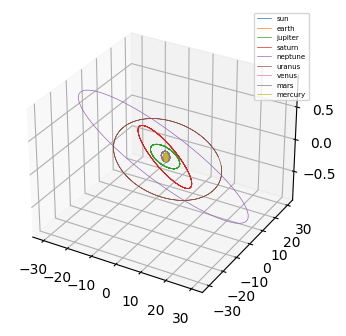

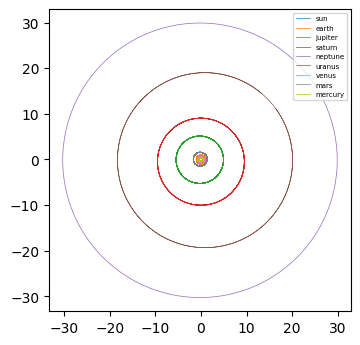

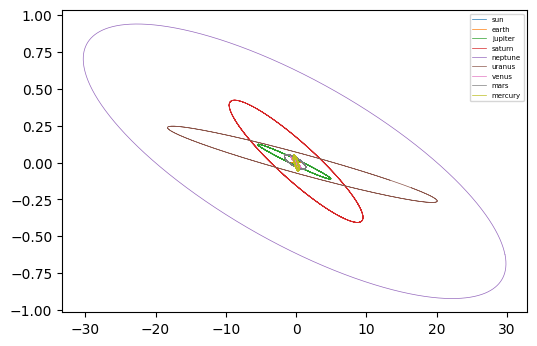

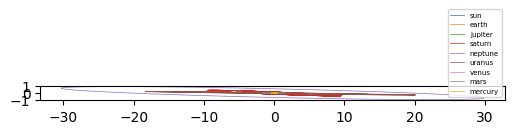

In [184]:
ax = plt.figure(dpi = 100).add_subplot(projection='3d')
# ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x[i], y[i], z[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x[i], y[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
# ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x[i], z[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x[i], z[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

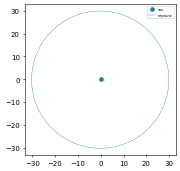

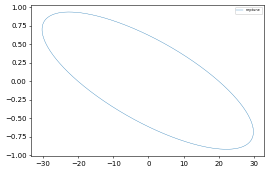

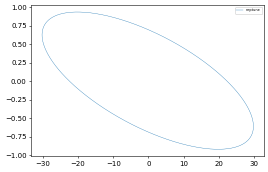

In [185]:
# ['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']

i_body = 4

fig = plt.figure(dpi = 50)
ax = plt.subplot()
ax.set_aspect("equal")
ax.scatter(x[0][0], y[0][0], label = bodies[0], linewidth = 0.5)
ax.plot(x[i_body], y[i_body], label = bodies[i_body], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 50)
ax = plt.subplot()
# ax.set_aspect("equal")
plt.plot(x[i_body], z[i_body], label = bodies[i_body], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 50)
ax = plt.subplot()
# ax.set_aspect("equal")
plt.plot(y[i_body], z[i_body], label = bodies[i_body], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

## 4. Plot horizons database data 

In [6]:
def get_horizon_trajectory(input_file, bodies, AU):
    horizons = pd.read_csv(input_file)
    display(horizons)
    n_timesteps = len(horizons)
    n_bodies = len(bodies)
    
    # initialization positions
    x = [[None] * (n_timesteps) for _ in range(n_bodies)]
    y = [[None] * (n_timesteps) for _ in range(n_bodies)]
    z = [[None] * (n_timesteps) for _ in range(n_bodies)]
    
    for i_body in range(n_bodies):
        body = bodies[i_body]
        print(body)
        data_horizons = horizons["position_%s"%(body)]
        for i_timestep in range(n_timesteps):
            # print("index timestep:", i_timestep)
            position = data_horizons[i_timestep].split(",")
            x[i_body][i_timestep] = float(position[0])/AU
            y[i_body][i_timestep] = float(position[1])/AU
            z[i_body][i_timestep] = float(position[2])/AU
    
    return x, y, z

In [7]:
input_file = "horizons_data_1750_250_years_to_plot_2_days_timestep.csv"
bodies = ['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']
n_bodies = len(bodies)

In [8]:
x_horizons, y_horizons, z_horizons = get_horizon_trajectory(input_file, bodies, AU)
print(len(x_horizons[0]))

,position_sun,velocity_sun,position_earth,velocity_earth,position_jupiter,velocity_jupiter,position_saturn,velocity_saturn,position_neptune,velocity_neptune,position_uranus,velocity_uranus,position_venus,velocity_venus,position_mars,velocity_mars,position_mercury,velocity_mercury
0,"-468011.8883121092,151780.3309712668,3952.9530...","-0.0003258233500816845,-0.01163403930534814,6....","-36208597.47896259,142827245.8730925,84067.570...","-29.38923058167892,-7.345469879141083,-0.00544...","734795831.9718618,87840456.21468413,-16884627....","-1.711418927962744,13.59088723021772,-0.015433...","-788974551.671683,-1263326095.890456,53745891....","7.651027428289614,-5.158165246598302,-0.209356...","-2220006937.202217,3899151159.679335,-29159071...","-4.754716874361391,-2.655525978864042,0.164120...","2433895323.08558,-1738528019.370214,-38340564....","3.902943987657815,5.228885111727971,-0.0310144...","69120594.23603946,82818405.06092733,-2953817.9...","-26.90275403106899,22.38941126504703,1.8487008...","177073702.4420656,122824201.1419298,-1896523.3...","-12.80692729641472,21.96789823182574,0.7801944...","-14940515.39784285,-68011809.8992632,-4204295....","37.89224236079752,-7.597936496536684,-4.119489..."
1,"-468064.7073609558,149770.6966681422,3963.8492...","-0.00028555128865315,-0.0116255746096807,6.256...","-41264159.51281495,141469199.3311797,83035.817...","-29.11800550992565,-8.371352426978527,-0.00649...","734496655.0725785,90188756.178365,-16887201.50...","-1.751179598380001,13.58803411053144,-0.014375...","-787651898.1182133,-1264216672.247371,53709675...","7.657473637871155,-5.149317710883157,-0.209861...","-2220828489.125536,3898692192.678835,-29130711...","-4.753983342459946,-2.656589235380636,0.164116...","2434569581.792266,-1737624341.938832,-38345924...","3.901044511149009,5.23033290066505,-0.03099853...","64365062.0880453,86555581.73236926,-2629889.46...","-28.12396039170685,20.85333564328739,1.8995008...","174825872.0339192,126595859.8255875,-1761340.6...","-13.20846033350038,21.68434972577906,0.7843650...","-8321162.876420539,-68925156.51717782,-4890248...","38.64673056713686,-2.959016721306415,-3.811791..."
2,"-468110.5899326733,147762.5466712139,3974.5765...","-0.0002455412444145021,-0.01161686192420608,6....","-46269619.25380602,139934604.97923,81829.20778...","-28.80926307829171,-9.388568676573536,-0.00745...","734190225.5661273,92536408.72318184,-16889604....","-1.793769442658308,13.58340431330406,-0.013423...","-786328162.2645447,-1265105664.452284,53673347...","7.663461198064603,-5.139916990788366,-0.210603...","-2221649912.947027,3898233043.423549,-29102352...","-4.753234214310697,-2.657635409247323,0.164115...","2435243494.005022,-1736720416.023571,-38351321...","3.898684857798951,5.231839476914285,-0.0312757...","59405963.80430972,90021441.41105749,-2297690.9...","-29.25819137437842,19.24996843917305,1.9443908...","172509265.628611,130317900.3085267,-1625465.60...","-13.60292637872593,21.39364678784365,0.7882089...","-1610013.890744383,-69030122.49762169,-5518913...","38.95299735337239,1.754946228705338,-3.4565609..."
3,"-468149.581877148,145755.9227400312,3985.13605...","-0.0002057995850061929,-0.01160791395093192,6....","-51218452.96257721,138225117.2123611,80469.952...","-28.46254495343246,-10.39522316150437,-0.00824...","733876557.7007287,94883107.93092236,-16891845....","-1.835897695413552,13.57825900803415,-0.012479...","-785003431.5487403,-1265993012.858529,53636885...","7.668926626311004,-5.130245272411353,-0.211437...","-2222471205.97166,3897773714.865362,-29073992....","-4.752469489939511,-2.658664500421717,0.164117...","2435917009.414824,-1735816225.000116,-38356714...","3.896518636624717,5.233344062506703,-0.0312488...","54258659.22918914,93204777.5834519,-1958257.39...","-30.30166621174175,17.58422596754266,1.9832154...","170125114.2708428,133989103.6207215,-1488954.4...","-13.99021221103274,21.09599002814467,0.7917275...","5114458.708700247,-68315517.9742103,-6082128.7...","38.79843538683296,

sun
earth
jupiter
saturn
neptune
uranus
venus
mars
mercury
45656


18300


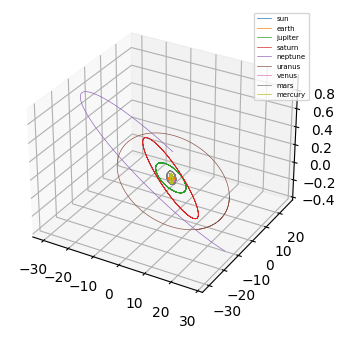

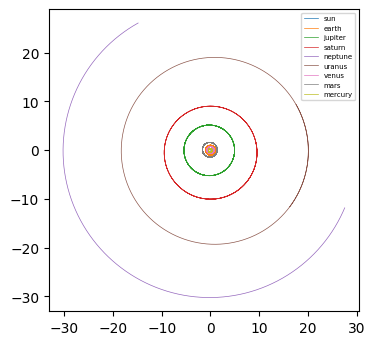

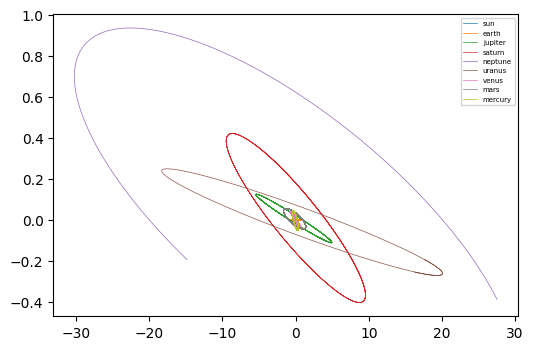

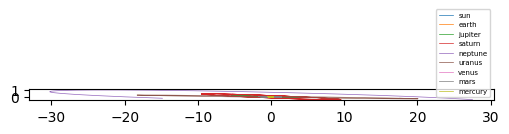

In [9]:
years_to_display = 100
range_to_display = int(((365 + 1) * years_to_display) / 2) # number of timesteps
print(range_to_display)
# rn, want to display "years_to_display" years but timestep is 2 days so divide by 2 to get number of timestep to display

ax = plt.figure(dpi = 100).add_subplot(projection='3d')
# ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x_horizons[i][:range_to_display], y_horizons[i][:range_to_display], z_horizons[i][:range_to_display], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x_horizons[i][:range_to_display], y_horizons[i][:range_to_display], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
# ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x_horizons[i][:range_to_display], z_horizons[i][:range_to_display], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x_horizons[i][:range_to_display], z_horizons[i][:range_to_display], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

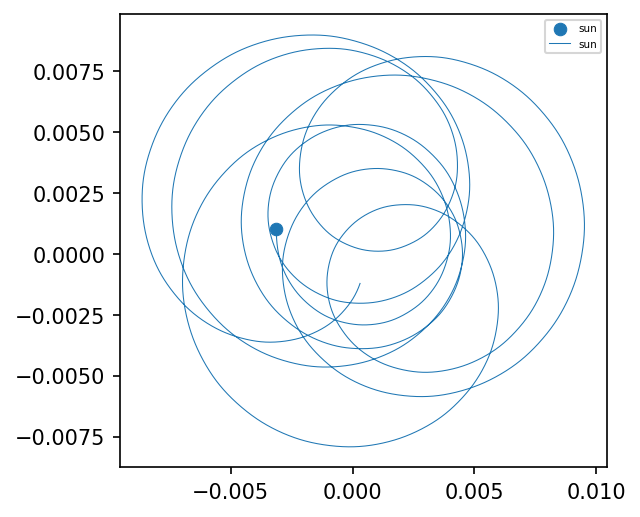

In [10]:
# ['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']

i_body = 0

fig = plt.figure(dpi = 150)
ax = plt.subplot()
ax.set_aspect("equal")
ax.scatter(x_horizons[0][0], y_horizons[0][0], label = bodies[0], linewidth = 0.5)
ax.plot(x_horizons[i_body][:range_to_display], y_horizons[i_body][:range_to_display], label = bodies[i_body], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

## 5. Compare horizons data I got with simulation

In [11]:
input_file = "new_horizons_data_init_01_01_1750.csv"

n_days_timestep = 2 # timestep in number of days
n_days_total = 365 * 165 # total number of days I want to simulate
n_timesteps = int(n_days_total/n_days_timestep) # number of timesteps for simulation
print("Number of timesteps:", n_timesteps)

timestep = (86400/year) * n_days_timestep # (86400/year) = 1 day in non dimensional
print("Timestep:", timestep)

# variables for Bulirsch-Stoer method
N = 4
h = timestep/N
q = 2
p = 1

func_integration = "Bulirsch-Stoer_optimized" #"Runga-Kutta" "Bulisrsch-Stoer"  "Runga-Kutta_optimized"
args_bulirsch_stoer = [N, h, q, p]

Number of timesteps: 30112
Timestep: 0.005475285171102661


In [12]:
n_bodies, bodies, x, y, z, exec_time = run_simulation(input_file, n_timesteps, timestep, func_integration, args_bulirsch_stoer, False)
print(exec_time)
print(bodies)

print(len(x[0]))

,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-4.680e+05,1.518e+05,3.953e+03,-3.258e-04,-0.012,6.355e-05,1.989e+30
earth,-3.621e+07,1.428e+08,8.407e+04,-2.939e+01,-7.345,-5.444e-03,5.972e+24
jupiter,7.348e+08,8.784e+07,-1.688e+07,-1.711e+00,13.591,-1.543e-02,1.899e+27
saturn,-7.890e+08,-1.263e+09,5.375e+07,7.651e+00,-5.158,-2.094e-01,5.683e+26
neptune,-2.220e+09,3.899e+09,-2.916e+07,-4.755e+00,-2.656,1.641e-01,1.024e+26
uranus,2.434e+09,-1.739e+09,-3.834e+07,3.903e+00,5.229,-3.101e-02,8.681e+25
venus,6.912e+07,8.282e+07,-2.954e+06,-2.690e+01,22.389,1.849e+00,4.867e+24
mars,1.771e+08,1.228e+08,-1.897e+06,-1.281e+01,21.968,7.802e-01,6.416e+23
mercury,-1.494e+07,-6.801e+07,-4.204e+06,3.789e+01,-7.598,-4.119e+00,3.285e+23


69.13483595848083
['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']
30113


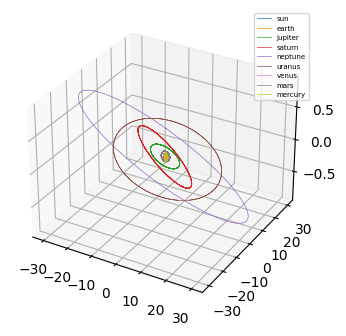

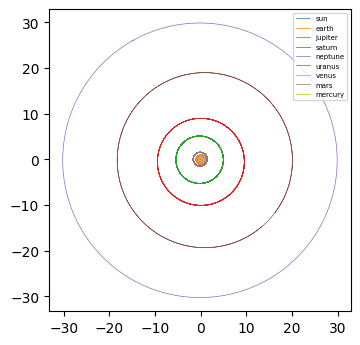

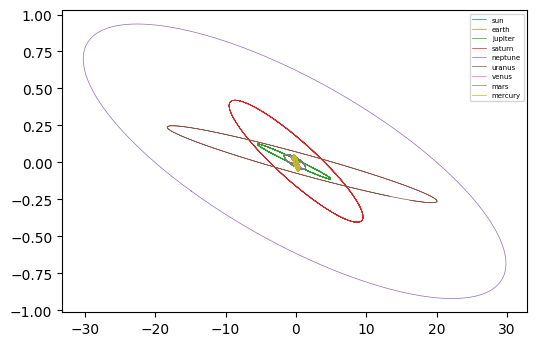

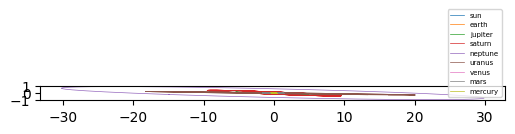

In [13]:
ax = plt.figure(dpi = 100).add_subplot(projection='3d')
for i in range(n_bodies):
    ax.plot(x[i], y[i], z[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x[i], y[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
# ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x[i], z[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x[i], z[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

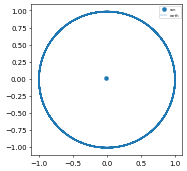

In [14]:
i_body = 1

fig = plt.figure(dpi = 50)
ax = plt.subplot()
ax.set_aspect("equal")
ax.scatter(x[0][0], y[0][0], label = bodies[0], linewidth = 0.5)
ax.plot(x[i_body], y[i_body], label = bodies[i_body], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

<ipython-input-34-c685e4750581>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-bright")


18250
18250
18250
18250
-0.0031284217133162383
-0.0031284217133162383


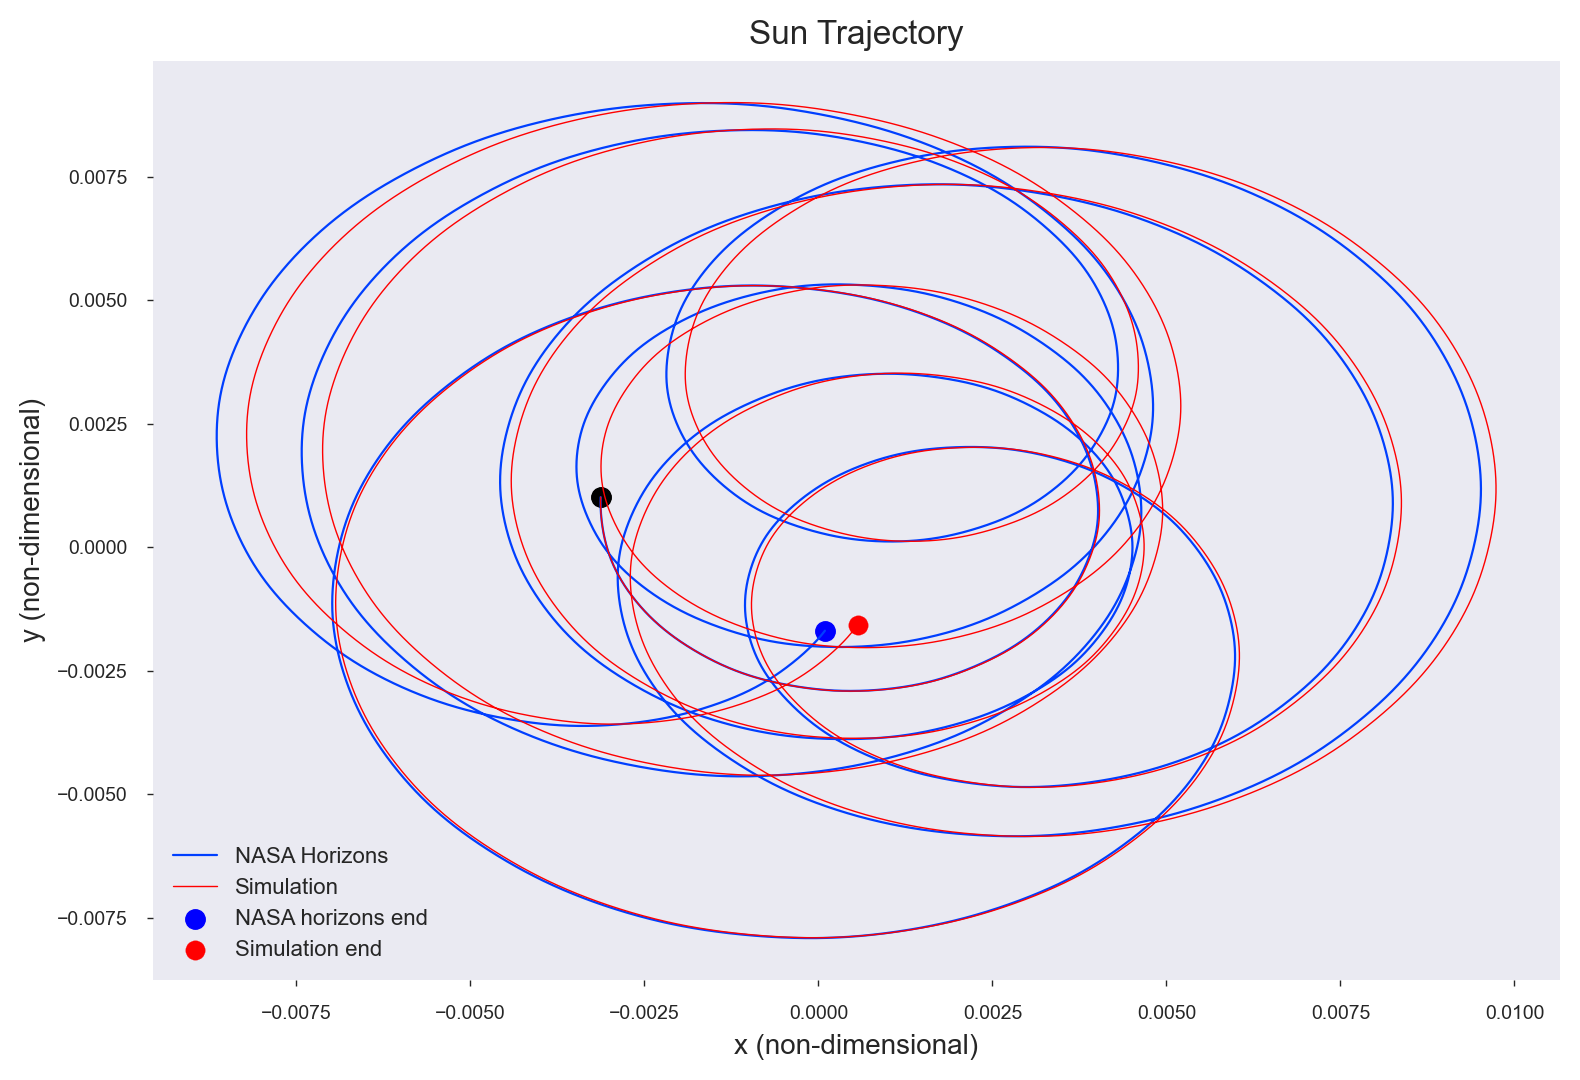

In [34]:
# now plot them together for a special body

plt.style.use("seaborn-bright")
# ['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']
i_body = 0
range_to_display_years = 365*100 + 1 # taking account initial conditions IN YEARS
timestep_horizons = 2
timestep_my_simulation = 2

x_horizons_plot = x_horizons[i_body][:int(range_to_display_years/timestep_horizons)]
y_horizons_plot = y_horizons[i_body][:int(range_to_display_years/timestep_horizons)]

print(len(x_horizons_plot))
print(len(y_horizons_plot))

x_simulation_plot = x[i_body][:int(range_to_display_years/timestep_my_simulation)]
y_simulation_plot = y[i_body][:int(range_to_display_years/timestep_my_simulation)]

print(len(x_simulation_plot))
print(len(y_simulation_plot))

print(x_simulation_plot[0])
print(x_horizons_plot[0])


fig = plt.figure(dpi = 200)
ax = plt.subplot()
# ax.set_aspect("equal")

ax.scatter(x_horizons_plot[0], y_horizons_plot[0], linewidth = 0.5, color = 'k')
ax.scatter(x_simulation_plot[0], y_simulation_plot[0], linewidth = 0.1, color = 'k')
ax.plot(x_horizons_plot, y_horizons_plot, label = "NASA Horizons", linewidth = 0.8)
ax.plot(x_simulation_plot, y_simulation_plot, label = "Simulation", linewidth = 0.5, color = 'r')
ax.scatter(x_horizons_plot[-1], y_horizons_plot[-1], label = "NASA horizons end", linewidth = 0.5, c = "b")
ax.scatter(x_simulation_plot[-1], y_simulation_plot[-1], label = "Simulation end", linewidth = 0.1, c = 'r')
# plt.title(bodies[i_body])
plt.title("Sun Trajectory")
ax.tick_params('both', length=2, width=0.5)
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=7)
ax.set_xlabel("x (non-dimensional)", size=10)
ax.set_ylabel("y (non-dimensional)", size = 10)
plt.grid(False)

ax.legend(fontsize="8")
plt.tight_layout()
plt.savefig("sun_trajectory.png")
plt.show()

In [16]:
orbits_2 = [827640/AU, 1.000, 5.2028, 9.5388, 30.0611, 19.1914, 0.7233, 1.5273, 0.3871] #in AU from
orbits_2 = [i * AU for i in orbits_2]
# print(orbits_2)


print(x_horizons_plot[0])
print(x_simulation_plot[0])

x_h = x_horizons_plot[1] * AU
x_sim = x_simulation_plot[1] * AU
print(x_h)
print(x_sim)

diff = ((x_h - x_sim)/orbits_2[i_body])
print("diff", diff)


# 0.45282235180165054
# 0.41512774436993266
# 67742223.82952692
# 62103110.557741925
# diff 0.037694607431717854

-0.24203607940483016
-0.24203607940483016
-41264159.512814954
-41263711.227663785
diff -2.9965584971170057e-06


## 6. Compare horizons data timestep by timestep

In [93]:
input_file = "horizons_data_1750_250_years_to_plot_1_day_timestep.csv"
bodies = ['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']
n_bodies = len(bodies)

x_horizons, y_horizons, z_horizons = get_horizon_trajectory(input_file, bodies, AU)
print(len(x_horizons[0]))

,position_sun,velocity_sun,position_earth,velocity_earth,position_jupiter,velocity_jupiter,position_saturn,velocity_saturn,position_neptune,velocity_neptune,position_uranus,velocity_uranus,position_venus,velocity_venus,position_mars,velocity_mars,position_mercury,velocity_mercury
0,"-468011.8883121092,151780.3309712668,3952.9530...","-0.0003258233500816845,-0.01163403930534814,6....","-36208597.47896259,142827245.8730925,84067.570...","-29.38923058167892,-7.345469879141083,-0.00544...","734795831.9718618,87840456.21468413,-16884627....","-1.711418927962744,13.59088723021772,-0.015433...","-788974551.671683,-1263326095.890456,53745891....","7.651027428289614,-5.158165246598302,-0.209356...","-2220006937.202217,3899151159.679335,-29159071...","-4.754716874361391,-2.655525978864042,0.164120...","2433895323.08558,-1738528019.370214,-38340564....","3.902943987657815,5.228885111727971,-0.0310144...","69120594.23603946,82818405.06092733,-2953817.9...","-26.90275403106899,22.38941126504703,1.8487008...","177073702.4420656,122824201.1419298,-1896523.3...","-12.80692729641472,21.96789823182574,0.7801944...","-14940515.39784285,-68011809.8992632,-4204295....","37.89224236079752,-7.597936496536684,-4.119489..."
1,"-468039.1677166351,150775.3309767457,3958.4223...","-0.0003056550274227369,-0.01162983873616061,6....","-38742236.75261412,142170382.3472707,83574.325...","-29.25827804579657,-7.859392759142129,-0.00597...","734647136.1720909,89014696.7935133,-16885935.8...","-1.731743426469674,13.59022752275403,-0.014882...","-788313364.3164943,-1263771574.430222,53727793...","7.654235135698367,-5.153825283709385,-0.209564...","-2220417729.008166,3898921699.145426,-29144891...","-4.754352057943261,-2.656059742450928,0.164118...","2434232495.178771,-1738076212.446586,-38343245...","3.90193963128686,5.229616663652145,-0.03104202...","66769208.03818177,84720174.73692687,-2792951.0...","-27.52398253230489,21.63008311666276,1.8748292...","175958460.404479,124716155.2207261,-1829022.11...","-13.00856984805005,21.82703078781289,0.7823206...","-11647139.64019275,-68568692.9033475,-4553918....","38.32491170528478,-5.289117709013563,-3.971629..."
2,"-468064.7073609558,149770.6966681422,3963.8492...","-0.00028555128865315,-0.0116255746096807,6.256...","-41264159.51281495,141469199.3311797,83035.817...","-29.11800550992565,-8.371352426978527,-0.00649...","734496655.0725785,90188756.178365,-16887201.50...","-1.751179598380001,13.58803411053144,-0.014375...","-787651898.1182133,-1264216672.247371,53709675...","7.657473637871155,-5.149317710883157,-0.209861...","-2220828489.125536,3898692192.678835,-29130711...","-4.753983342459946,-2.656589235380636,0.164116...","2434569581.792266,-1737624341.938832,-38345924...","3.901044511149009,5.23033290066505,-0.03099853...","64365062.0880453,86555581.73236926,-2629889.46...","-28.12396039170685,20.85333564328739,1.8995008...","174825872.0339192,126595859.8255875,-1761340.6...","-13.20846033350038,21.68434972577906,0.7843650...","-8321162.876420539,-68925156.51717782,-4890248...","38.64673056713686,-2.959016721306415,-3.811791..."
3,"-468088.5128666391,148766.4334699427,3969.2339...","-0.0002655130787210674,-0.01162124847891186,6....","-43773557.99997651,140723874.8666531,82453.360...","-28.96835423706928,-8.881150996416851,-0.00698...","734344362.9454836,91362739.14350607,-16888421....","-1.774344342856388,13.58607427886506,-0.013916...","-786990159.1505125,-1264661371.073127,53691527...","7.660520165126452,-5.144634680292894,-0.210228...","-2221239217.21745,3898462640.648547,-29116531....","-4.753610727914682,-2.657114457647868,0.164115...","2434906591.610641,-1737172411.803006,-38348614...","3.900008806589697,5.231031452721469,-0.0313027...","61910014.03746683,88323146.51634848,-2464759.8...","-28.70219035485524,20.05976158732507,1.9226947...","173676089.3494394,128463159.3399994,-1693486.1...","-13.4065839642324,21.53988004016042,0.78632780...","-4972209.407780342,-69079470.39191034,-5212254...","38.85656713098543,

sun
earth
jupiter
saturn
neptune
uranus
venus
mars
mercury
54787


In [101]:
input_file = "new_horizons_data_init_01_01_1750.csv"

n_days_timestep = 1 # timestep in number of days
n_days_total = 365 * 50 # total number of days I want to simulate
n_timesteps = int(n_days_total/n_days_timestep) # number of timesteps for simulation
print("Number of timesteps:", n_timesteps)

timestep = (86400/year) * n_days_timestep # (86400/year) = 1 day in non dimensional
print("Timestep:", timestep)

# variables for Bulirsch-Stoer method
N = 4
h = timestep/N
q = 2
p = 1

func_integration = "Bulirsch-Stoer_optimized" #"Runga-Kutta" "Bulisrsch-Stoer"  "Runga-Kutta_optimized"
args_bulirsch_stoer = [N, h, q, p]

n_bodies, bodies, x, y, z, exec_time = run_simulation(input_file, n_timesteps, timestep, func_integration, args_bulirsch_stoer, False)
print(exec_time)
print(bodies)
# print(len(x[0]))

Number of timesteps: 18250
Timestep: 0.0027376425855513307


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-4.680e+05,1.518e+05,3.953e+03,-3.258e-04,-0.012,6.355e-05,1.989e+30
earth,-3.621e+07,1.428e+08,8.407e+04,-2.939e+01,-7.345,-5.444e-03,5.972e+24
jupiter,7.348e+08,8.784e+07,-1.688e+07,-1.711e+00,13.591,-1.543e-02,1.899e+27
saturn,-7.890e+08,-1.263e+09,5.375e+07,7.651e+00,-5.158,-2.094e-01,5.683e+26
neptune,-2.220e+09,3.899e+09,-2.916e+07,-4.755e+00,-2.656,1.641e-01,1.024e+26
uranus,2.434e+09,-1.739e+09,-3.834e+07,3.903e+00,5.229,-3.101e-02,8.681e+25
venus,6.912e+07,8.282e+07,-2.954e+06,-2.690e+01,22.389,1.849e+00,4.867e+24
mars,1.771e+08,1.228e+08,-1.897e+06,-1.281e+01,21.968,7.802e-01,6.416e+23
mercury,-1.494e+07,-6.801e+07,-4.204e+06,3.789e+01,-7.598,-4.119e+00,3.285e+23


x -36208597.47896259
y 142827245.8730925
z 84067.57016955316
Vx -29.38923058167892
Vy -7.345469879141083
Vz -0.0054443760948568
41.115869998931885
['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']


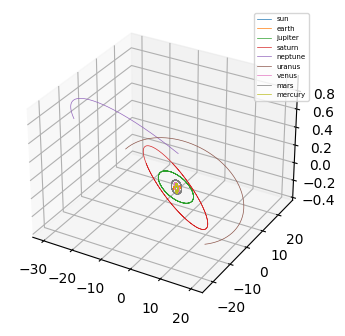

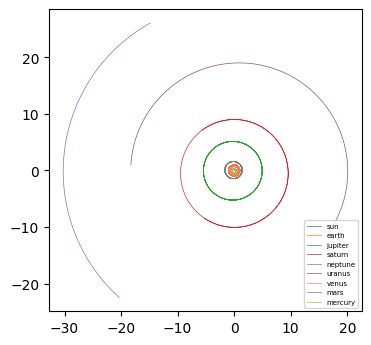

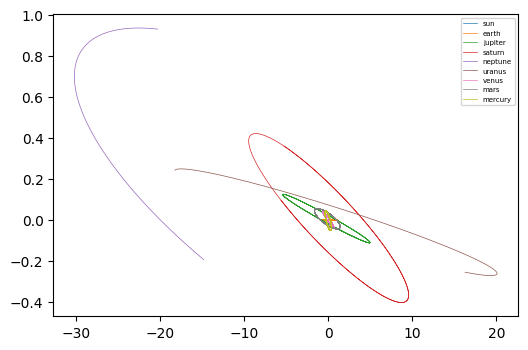

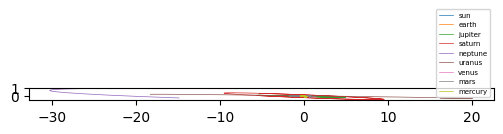

In [102]:
ax = plt.figure(dpi = 100).add_subplot(projection='3d')
for i in range(n_bodies):
    ax.plot(x[i], y[i], z[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x[i], y[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
# ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x[i], z[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x[i], z[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

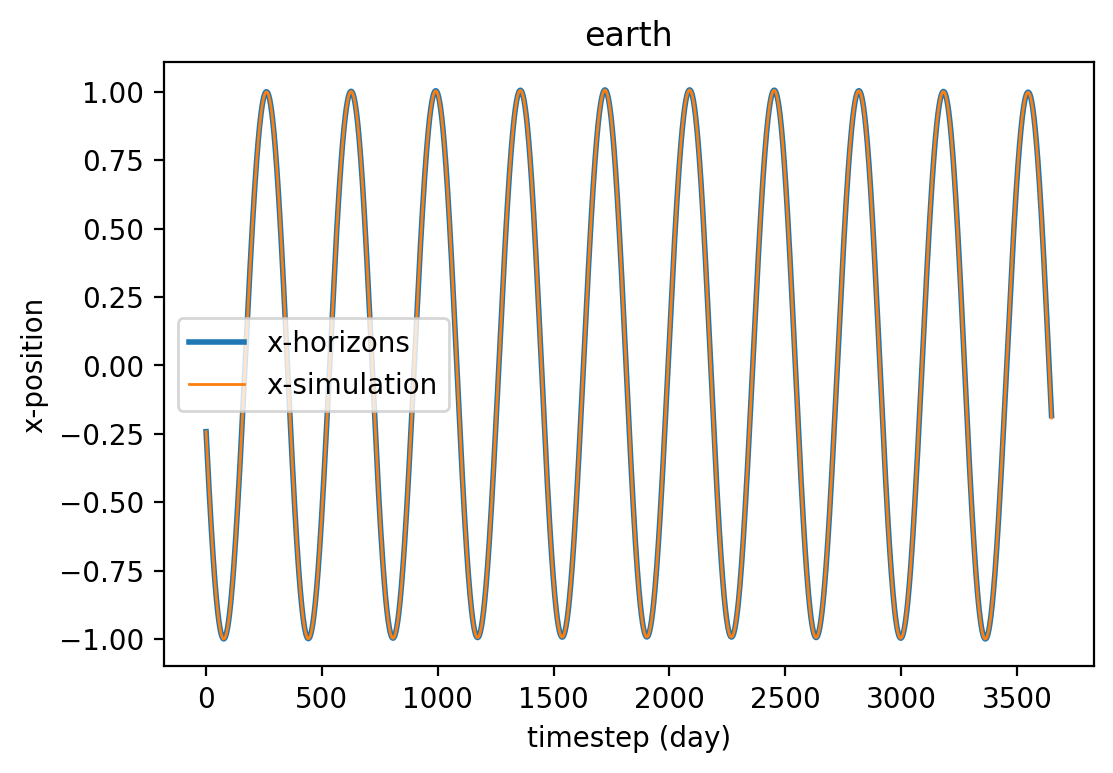

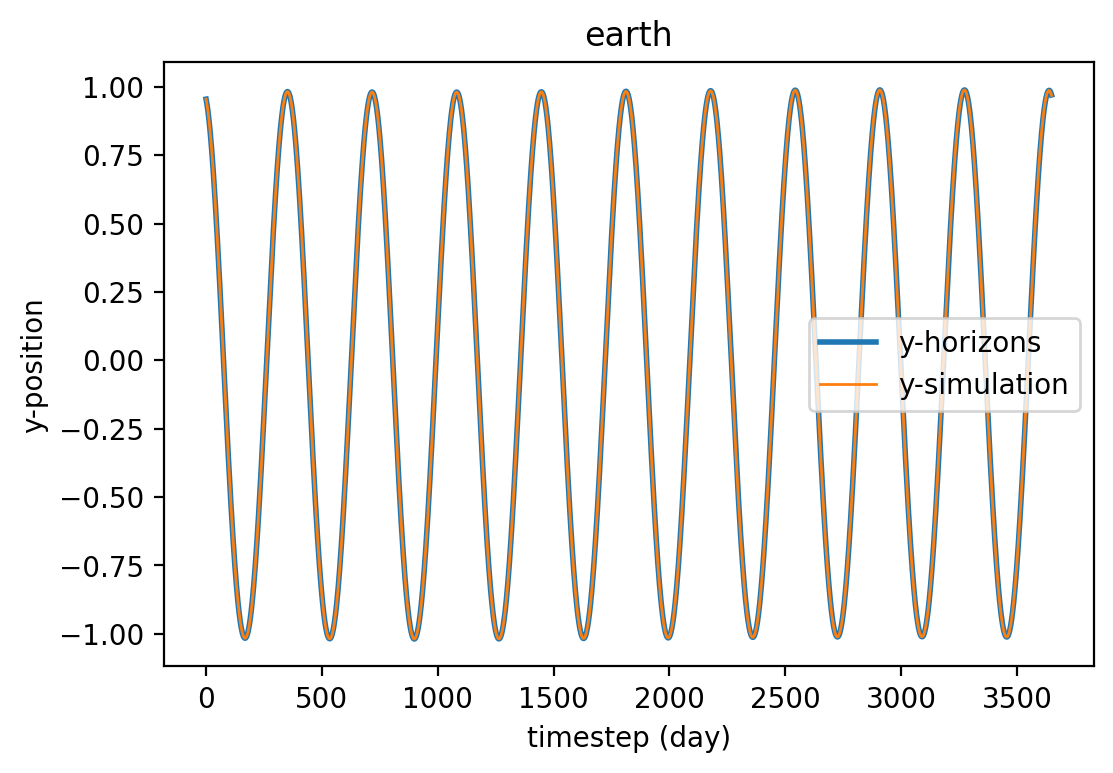

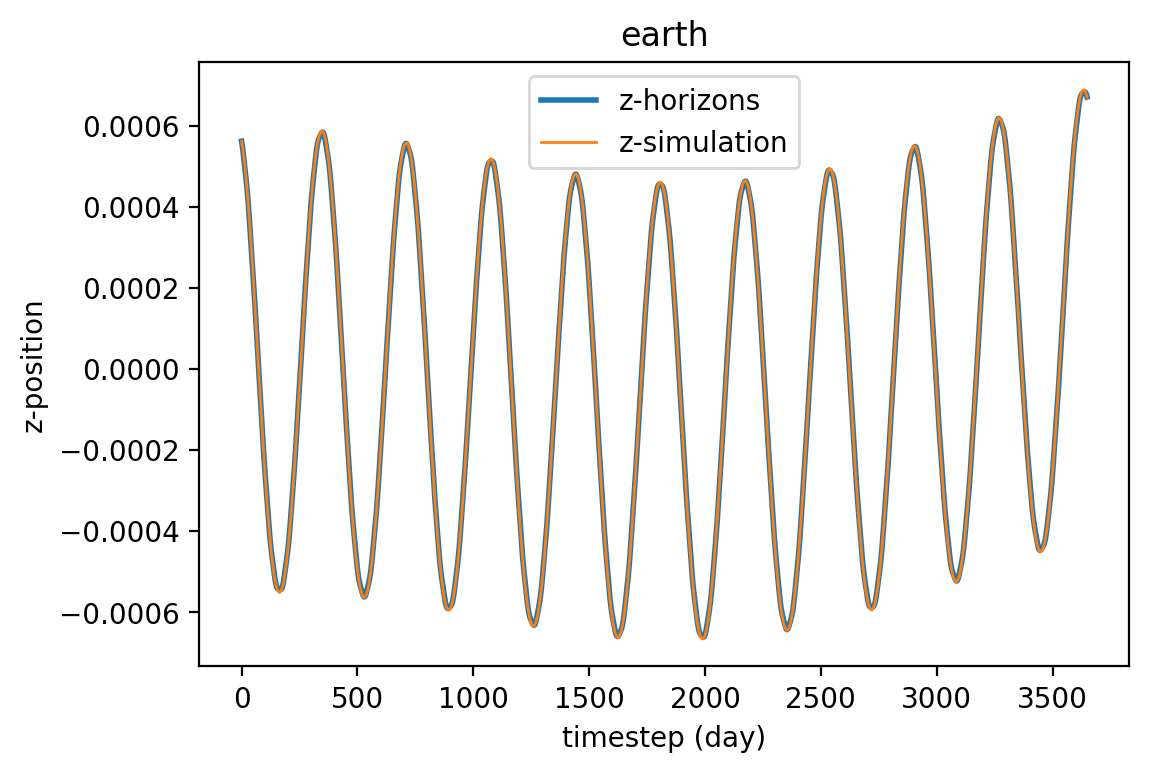

-36208597.47896259
-36208597.47896259
-38742236.75261412
-38742126.1080653


In [104]:
# now plot x, y z and x_horizon, y_hprozon, z_horizon for a special body for 100 timesteps (= 100 days)

i_body = 1 # ['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']
n_timesteps_compare = 365*10 # assume timsteps are same for horizon and my simulation in this context
x_axis_timesteps = list(range(n_timesteps_compare))

x_horizons_plot = x_horizons[i_body][:n_timesteps_compare]
y_horizons_plot = y_horizons[i_body][:n_timesteps_compare]
z_horizons_plot = z_horizons[i_body][:n_timesteps_compare]

x_simulation_plot = x[i_body][:n_timesteps_compare]
y_simulation_plot = y[i_body][:n_timesteps_compare]
z_simulation_plot = z[i_body][:n_timesteps_compare]


fig = plt.figure(dpi = 200)
plt.plot(x_axis_timesteps, x_horizons_plot, label = "x-horizons", linewidth = 2)
plt.plot(x_axis_timesteps, x_simulation_plot, label = "x-simulation", linewidth = 1)
plt.legend()
plt.xlabel("timestep (day)")
plt.ylabel("x-position")
plt.title(bodies[i_body])
plt.show()

fig = plt.figure(dpi = 200)
plt.plot(x_axis_timesteps, y_horizons_plot, label = "y-horizons", linewidth = 2)
plt.plot(x_axis_timesteps, y_simulation_plot, label = "y-simulation", linewidth = 1)
plt.legend()
plt.xlabel("timestep (day)")
plt.ylabel("y-position")
plt.title(bodies[i_body])
plt.show()

fig = plt.figure(dpi = 200)
plt.plot(x_axis_timesteps, z_horizons_plot, label = "z-horizons", linewidth = 2)
plt.plot(x_axis_timesteps, z_simulation_plot, label = "z-simulation", linewidth = 1)
plt.legend()
plt.xlabel("timestep (day)")
plt.ylabel("z-position")
plt.title(bodies[i_body])
plt.show()



print(x_horizons_plot[0] * AU)
print(x_simulation_plot[0] * AU)

print(x_horizons_plot[1] * AU)
print(x_simulation_plot[1] * AU)

## 7. Radial velocity of the sun

In [108]:
input_file = "new_horizons_data_init_01_01_1750.csv"

n_days_timestep = 1 # timestep in number of days
n_days_total = 365 * 200 # total number of days I want to simulate
n_timesteps = int(n_days_total/n_days_timestep) # number of timesteps for simulation
print("Number of timesteps:", n_timesteps)

timestep = (86400/year) * n_days_timestep # (86400/year) = 1 day in non dimensional
print("Timestep:", timestep)

# variables for Bulirsch-Stoer method
N = 4
h = timestep/N
q = 2
p = 1

func_integration = "Bulirsch-Stoer_optimized" #"Runga-Kutta" "Bulisrsch-Stoer"  "Runga-Kutta_optimized"
args_bulirsch_stoer = [N, h, q, p]

n_bodies, bodies, x, y, z, exec_time, Vx, Vy, Vz = run_simulation(input_file, n_timesteps, timestep, func_integration, args_bulirsch_stoer, True)
print(exec_time)
print(bodies)
# print(len(x[0]))

Number of timesteps: 73000
Timestep: 0.0027376425855513307


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-4.680e+05,1.518e+05,3.953e+03,-3.258e-04,-0.012,6.355e-05,1.989e+30
earth,-3.621e+07,1.428e+08,8.407e+04,-2.939e+01,-7.345,-5.444e-03,5.972e+24
jupiter,7.348e+08,8.784e+07,-1.688e+07,-1.711e+00,13.591,-1.543e-02,1.899e+27
saturn,-7.890e+08,-1.263e+09,5.375e+07,7.651e+00,-5.158,-2.094e-01,5.683e+26
neptune,-2.220e+09,3.899e+09,-2.916e+07,-4.755e+00,-2.656,1.641e-01,1.024e+26
uranus,2.434e+09,-1.739e+09,-3.834e+07,3.903e+00,5.229,-3.101e-02,8.681e+25
venus,6.912e+07,8.282e+07,-2.954e+06,-2.690e+01,22.389,1.849e+00,4.867e+24
mars,1.771e+08,1.228e+08,-1.897e+06,-1.281e+01,21.968,7.802e-01,6.416e+23
mercury,-1.494e+07,-6.801e+07,-4.204e+06,3.789e+01,-7.598,-4.119e+00,3.285e+23


172.67797303199768
['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']


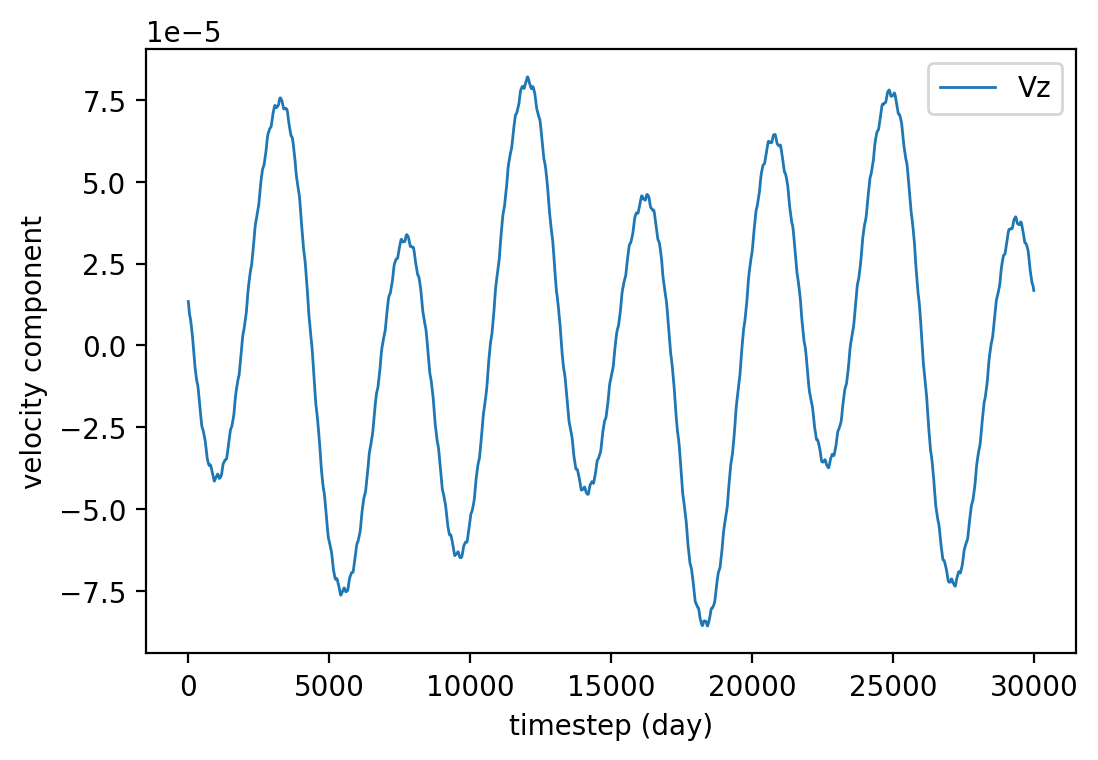

In [117]:
x_axis_plot = list(range(n_timesteps + 1))
timesteps_to_display = 10000*3

fig = plt.figure(dpi = 200)
# plt.plot(x_axis_plot[:timesteps_to_display], Vx[0][:timesteps_to_display], label = "Vx", linewidth = 1)
# plt.plot(x_axis_plot[:timesteps_to_display], Vy[0][:timesteps_to_display], label = "Vy", linewidth = 1)
plt.plot(x_axis_plot[:timesteps_to_display], Vz[0][:timesteps_to_display], label = "Vz", linewidth = 1)
plt.legend()
plt.xlabel("timestep (day)")
plt.ylabel("velocity component")
plt.show()


## 8. Lyuopanov exponent

In [118]:
def lyapunov_exponent(t0, t, dt0, dt):
    return (math.log(dt) - math.log(dt0))/(t-t0)

def lyapunov_exponent_bis(t0, t, dt0, dt):
    return (math.log(dt) - math.log(dt0))/(t-t0)

In [153]:
t0 = 0
t = 1

dt0 = 0.0000001
dt = 0.000001

print(lyapunov_exponent(t0, t, dt0, dt))

2.302585092994047


In [138]:
# body_change: which body to change initial condition
# changes: [for x, y, z, Vx, Vy, Vz]

def run_simulation_lyapunov(input_file, n_timesteps, timestep, func_integration, args, return_velocity, body_change, changes):
    df = pd.read_csv(input_file)
    bodies = list(df['body'])
    df = df.set_index('body')
    n_bodies = len(df)
    # print(n_bodies, "bodies:", bodies)
#     display(df)
    
    # set array of masses and normalize
    m = list(df["mass"])
    m = [i/mass_sun for i in m]
    # print("Masses:", m)

    # initialization positions and velocities
    x = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    y = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    z = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    Vx = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    Vy = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    Vz = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    
    for n in range(n_bodies):
        row = df.loc[bodies[n]] 
        if n != body_change:
            x[n][0] = float(row.x)/AU
            y[n][0] = float(row.y)/AU
            z[n][0] = float(row.z)/AU
            
            Vx[n][0] = float(row.Vx)*(year/AU)
            Vy[n][0] = float(row.Vy)*(year/AU)
            Vz[n][0] = float(row.Vz)*(year/AU)
        else:
            x[n][0] = float(row.x)/AU + changes[0]
            y[n][0] = float(row.y)/AU + changes[1]
            z[n][0] = float(row.z)/AU + changes[2]
            
            Vx[n][0] = float(row.Vx)*(year/AU) + changes[3]
            Vy[n][0] = float(row.Vy)*(year/AU) + changes[4]
            Vz[n][0] = float(row.Vz)*(year/AU) + changes[5]
            

    if func_integration == "Bulirsch-Stoer" or func_integration == "Bulirsch-Stoer_optimized":
        N = args[0]
        h = args[1]
        q = args[2]
        p = args[3]
    
    start_time = time.time()
    # run simulation
    for t in range(n_timesteps):
        # set array with latest position for all bodies
        x_last_all = [None] * n_bodies
        y_last_all = [None] * n_bodies
        z_last_all = [None] * n_bodies
        
        for n in range(n_bodies):
            x_last_all[n] = x[n][t]
            y_last_all[n] = y[n][t]
            z_last_all[n] = z[n][t]
            
        for n in range(n_bodies):
            # for a specific body: p_components are its position, c_components are its velocity components
            p_components = (x_last_all[n], y_last_all[n], z_last_all[n])
            v_components = (Vx[n][t], Vy[n][t], Vz[n][t])

            args_x = (n, m, "x", x_last_all, y_last_all, z_last_all, norm_const)
            args_y = (n, m, "y", x_last_all, y_last_all, z_last_all, norm_const)
            args_z = (n, m, "z", x_last_all, y_last_all, z_last_all, norm_const)
            
            if func_integration == "Bulirsch-Stoer":
                p_components, v_components = bulirsch_stoer_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
            elif func_integration == "Bulirsch-Stoer_optimized":
                p_components, v_components = bulirsch_stoer_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
            elif func_integration == "Runga-Kutta":
                p_components, v_components = runga_kutta_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
            elif func_integration == "Runga-Kutta_optimized":
                p_components, v_components = runga_kutta_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
        
            # add new value in arrays
            x[n][t+1] = p_components[0]
            y[n][t+1] = p_components[1]
            z[n][t+1] = p_components[2]

            Vx[n][t+1] = v_components[0]
            Vy[n][t+1] = v_components[1]
            Vz[n][t+1] = v_components[2]
            
    exec_time = time.time() - start_time
    if return_velocity == True:
        return n_bodies, bodies, x, y, z, exec_time, Vx, Vy, Vz
    return n_bodies, bodies, x, y, z, exec_time

In [143]:
# trajectory used as basis
input_file = "new_horizons_data_init_01_01_1750.csv"

n_days_timestep = 1 # timestep in number of days
n_days_total = 365 * 1 # total number of days I want to simulate
n_timesteps = int(n_days_total/n_days_timestep) # number of timesteps for simulation
print("Number of timesteps:", n_timesteps)
timestep = (86400/year) * n_days_timestep 
print("Timestep:", timestep)

# variables for Bulirsch-Stoer method
N = 4
h = timestep/N
q = 2
p = 1

func_integration = "Bulirsch-Stoer_optimized" #"Runga-Kutta" "Bulisrsch-Stoer"  "Runga-Kutta_optimized"
args_bulirsch_stoer = [N, h, q, p]

n_bodies, bodies, x, y, z, exec_time, Vx, Vy, Vz = run_simulation(input_file, n_timesteps, timestep, func_integration, args_bulirsch_stoer, True)
print(exec_time)
print(bodies)
print(len(x[0]))

Number of timesteps: 365
Timestep: 0.0027376425855513307


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-4.680e+05,1.518e+05,3.953e+03,-3.258e-04,-0.012,6.355e-05,1.989e+30
earth,-3.621e+07,1.428e+08,8.407e+04,-2.939e+01,-7.345,-5.444e-03,5.972e+24
jupiter,7.348e+08,8.784e+07,-1.688e+07,-1.711e+00,13.591,-1.543e-02,1.899e+27
saturn,-7.890e+08,-1.263e+09,5.375e+07,7.651e+00,-5.158,-2.094e-01,5.683e+26
neptune,-2.220e+09,3.899e+09,-2.916e+07,-4.755e+00,-2.656,1.641e-01,1.024e+26
uranus,2.434e+09,-1.739e+09,-3.834e+07,3.903e+00,5.229,-3.101e-02,8.681e+25
venus,6.912e+07,8.282e+07,-2.954e+06,-2.690e+01,22.389,1.849e+00,4.867e+24
mars,1.771e+08,1.228e+08,-1.897e+06,-1.281e+01,21.968,7.802e-01,6.416e+23
mercury,-1.494e+07,-6.801e+07,-4.204e+06,3.789e+01,-7.598,-4.119e+00,3.285e+23


0.9058308601379395
['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']
366


In [156]:
# question 1: how is earth trajectory dependent on other planets?
# change Vx of each body by 2% of Vx

for n in range(len(bodies)):
    if n != 1: # if it s not earth
        print(bodies[n])
        changes = [0, 0, 0, abs(0.5 * Vx[n][0]), 0, 0]
        n_bodies, bodies, x_bis, y_bis, z_bis, exec_time_bis, Vx_bis, Vy_bis, Vz_bis = run_simulation_lyapunov(input_file, n_timesteps, timestep, func_integration, args_bulirsch_stoer, True, n, changes)

        # check the exponent for earth
        t0 = 0
        t = n_timesteps
        dt0 = 0.000000000000000000001 # because no change for earth # abs(0.02 * Vx[n][0])
        dt = abs(Vx_bis[1][-1] - Vx[1][-1])

        print("Lyapunov Exponent:", lyapunov_exponent(t0, t, dt0, dt))
    

['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']
sun
Lyapunov Exponent: 0.1084961744361557
jupiter
Lyapunov Exponent: 0.10505983484253413
saturn
Lyapunov Exponent: 0.09577357412537241
neptune
Lyapunov Exponent: 0.07880115896890638
uranus
Lyapunov Exponent: 0.08627143121722694
venus
Lyapunov Exponent: 0.11000874871118158
mars
Lyapunov Exponent: 0.09278154304657317
mercury
Lyapunov Exponent: 0.09632096326362882


In [157]:
# question 2: how is earth trajectory dependent its initial velocity?

changes = [0, 0, 0, abs(0.01 * Vx[1][0]), 0, 0]
n_bodies, bodies, x_bis, y_bis, z_bis, exec_time_bis, Vx_bis, Vy_bis, Vz_bis = run_simulation_lyapunov(input_file, n_timesteps, timestep, func_integration, args_bulirsch_stoer, True, 1, changes)

# check the exponent for earth
t0 = 0
t = n_timesteps
dt0 =  abs(0.01 * Vx[1][0])
dt = abs(Vx_bis[1][-1] - Vx[1][-1])

print("Lyapunov Exponent:", lyapunov_exponent(t0, t, dt0, dt))


changes = [0, 0, 0, 0, abs(0.01 * Vy[1][0]), 0]
n_bodies, bodies, x_bis, y_bis, z_bis, exec_time_bis, Vx_bis, Vy_bis, Vz_bis = run_simulation_lyapunov(input_file, n_timesteps, timestep, func_integration, args_bulirsch_stoer, True, 1, changes)

# check the exponent for earth
t0 = 0
t = n_timesteps
dt0 =  abs(0.01 * Vy[1][0])
dt = abs(Vy_bis[1][-1] - Vy[1][-1])

print("Lyapunov Exponent:", lyapunov_exponent(t0, t, dt0, dt))


Lyapunov Exponent: 0.005372303761552516
